# **Group 1 Final Project - Spotify Predictions**

### **Names: Arnav Sareen, Bita Ghaffari, Carter Leonard, Rushil Jadia, Sindhu Gadiraju, Sogol Maghzian**

### **Introduction**

Here is the intro to the project, giving information on the problem and how we are trying to solve it. We will go in detail on what the data is, what we will do with it, and other necessary introduction information.

# Data Collection
### *By Arnav Sareen*

Though our dataset is already quite large, with something as personal and sometimes niche as music, people are inevitably like more songs that lie outside the dataset then in it. Thus, there is a need for our dataset to be expanded and enhanced with more songs so that users can get the most accurate recommendations possible. However, the primary issue with this that prevents it from being a one-step API call is that Spotify recently deprecated its Audio Features API, meaning that we had to find alternative methods to locate, extract, and integrate new data into our dataset.

In [ ]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException
import http.client
import deezer
from dotenv import load_dotenv
from mutagen.mp3 import MP3
import io
import os.path
import tempfile
import requests
import os
import random
from pydub import AudioSegment
from pydub.utils import which
import boto3
from botocore.client import Config

In [ ]:
# Cell to get a dependency for one of my packages loaded up in the right manner
os.environ["PATH"] += os.pathsep + r"C:\ffmpeg\ffmpeg-7.1.1-essentials_build\bin"
AudioSegment.converter = which("ffmpeg")
AudioSegment.ffprobe = which("ffprobe")

In [ ]:
# Load in the dataframes
high_popularity_df: pd.DataFrame = pd.read_csv('./data/high_popularity_spotify_data.csv')
low_popularity_df: pd.DataFrame = pd.read_csv('./data/low_popularity_spotify_data.csv')

In [ ]:
print(f'There are {high_popularity_df.shape[0]:,} rows in the high popularity dataset')
high_popularity_df.head(20)

There are 1,686 rows in the high popularity dataset


,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.1220,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.000000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.30800,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.1170,0.438,Billie Eilish,4,0.0358,...,0.060800,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.20000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.1590,0.372,Gracie Abrams,4,0.0368,...,0.000000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.21400,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.3040,0.786,Sabrina Carpenter,4,0.0634,...,0.000000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.09390,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.3550,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,0.000000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.02830,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
5,0.582,116.712,0.700,pop,-5.960,0.0881,0.785,Chappell Roan,4,0.0356,...,0.000000,1WAjjRMfZjEXtB0lQrAw6Q,0,11,218424,0.05020,0WbMK4wrZ1wFSty9F7FCgu,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
6,0.561,150.069,0.669,pop,-6.538,0.0954,0.841,Addison Rae,4,0.0411,...,0.009620,0XA403JTounqFh2owquBXu,1,10,169698,0.49500,6MzofobZt2dm0Kf1hTThFz,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
7,0.247,148.101,0.467,pop,-12.002,0.1700,0.126,Billie Eilish,4,0.0431,...,0.000271,7aJuG4TFXa2hmE4z1yxc3n,0,6,261467,0.61200,3QaPy1KgI7nu9FJEQUgn6h,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
8,0.416,94.926,0.492,pop,-10.439,0.2030,0.297,Gigi Perez,4,0.0254,...,0.000086,4DWrYvfGXRE8ko5ZxlIpit,1,11,211979,0.68600,0UYnhUfnUj5adChuAXvLUB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
9,0.722,119.973,0.769,pop,-5.485,0.1110,0.570,"The Weeknd, Playboi Carti",4,0.0507,...,0.000003,2IRxVVqbSbqHJo8Zx50LYn,0,11,256000,0.05840,1Es7AUAhQvapIcoh3qMKDL,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


In [ ]:
print(f'There are {low_popularity_df.shape[0]:,} rows in the low popularity dataset')
low_popularity_df.head(20)

There are 3,145 rows in the low popularity dataset


,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.7460,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.4320,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.8350,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.7950,0.0,129.981,-6.219,0.1710,0.0702,The Collection
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.8040,rock,classic,...,3S404OgKoVQSJ3xXrDVlp8,37i9dQZF1DWXRqgorJj26U,5LNiqEqpDc8TuqPy79kDBu,0.6580,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition)
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.1040,jazz,classic,...,1y5KGkUKO0NG32MhIIagCA,37i9dQZF1DXbITWG1ZJKYt,78MI7mu1LV1k4IA2HzKmHe,0.3940,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella"
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.4720,jazz,classic,...,6f4b9wVTkKAf096k4XG6x5,37i9dQZF1DXbITWG1ZJKYt,6MN6yRVriszuyAVlyF8ndB,0.4750,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter
5,4.0,61,0.0566,0.670,Jazz Classics,"Frank Sinatra, Count Basie",147147.0,0.3650,jazz,classic,...,7gmak9ZGm10y4PtZa9SBQn,37i9dQZF1DXbITWG1ZJKYt,2dR5WkrpwylTuT3jRWNufa,0.4500,0.0,119.347,-10.158,0.5250,0.0575,Ultimate Sinatra
6,4.0,60,0.0914,0.663,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",354533.0,0.2640,jazz,classic,...,2uqlkJu6vckJahCsp6Hfcn,37i9dQZF1DXbITWG1ZJKYt,33jt3kYWjQzqn3xyYQ5ZEh,0.6570,0.0,122.482,-14.571,0.7060,0.1000,The Complete Ella And Louis On Verve
7,4.0,55,0.0373,0.525,Jazz Classics,Benny Goodman,195533.0,0.2220,jazz,classic,...,33oCBSZiLbfqyOnTTQ4Tct,37i9dQZF1DXbITWG1ZJKYt,1xUJ1mdLAysxNBtO9w3J2g,0.6450,10.0,156.364,-11.065,0.8360,0.0510,B. G. In Hi Fi
8,4.0,54,0.0363,0.336,Jazz Classics,Kenny Dorham,190400.0,0.0619,jazz,classic,...,4B0pF1WLB3pCaZ4eTx5U8S,37i9dQZF1DXbITWG1ZJKYt,3GOZbK2epuHzCt5YvvVFHO,0.1970,5.0,60.705,-20.494,0.9850,0.1100,Quiet Kenny
9,4.0,53,0.0407,0.742,Jazz Classics,Horace Silver,438280.0,0.6710,jazz,classic,...,4LEnATSqKeANOJ0mLUAuCE,37i9dQZF1DXbITWG1ZJKYt,1CDBaGlisZlOJzvx88lL8A,0.5910,5.0,127.359,-8.142,0.7940,0.1220,Song For My Father


In [ ]:
df: pd.DataFrame = pd.concat([low_popularity_df, high_popularity_df], axis = 0)
print(f'There are {df.shape[0]:,} rows in the combined dataset')
df.head(20)

There are 4,831 rows in the combined dataset


,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.7460,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.4320,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.8350,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.7950,0.0,129.981,-6.219,0.1710,0.0702,The Collection
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.8040,rock,classic,...,3S404OgKoVQSJ3xXrDVlp8,37i9dQZF1DWXRqgorJj26U,5LNiqEqpDc8TuqPy79kDBu,0.6580,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition)
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.1040,jazz,classic,...,1y5KGkUKO0NG32MhIIagCA,37i9dQZF1DXbITWG1ZJKYt,78MI7mu1LV1k4IA2HzKmHe,0.3940,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella"
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.4720,jazz,classic,...,6f4b9wVTkKAf096k4XG6x5,37i9dQZF1DXbITWG1ZJKYt,6MN6yRVriszuyAVlyF8ndB,0.4750,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter
5,4.0,61,0.0566,0.670,Jazz Classics,"Frank Sinatra, Count Basie",147147.0,0.3650,jazz,classic,...,7gmak9ZGm10y4PtZa9SBQn,37i9dQZF1DXbITWG1ZJKYt,2dR5WkrpwylTuT3jRWNufa,0.4500,0.0,119.347,-10.158,0.5250,0.0575,Ultimate Sinatra
6,4.0,60,0.0914,0.663,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",354533.0,0.2640,jazz,classic,...,2uqlkJu6vckJahCsp6Hfcn,37i9dQZF1DXbITWG1ZJKYt,33jt3kYWjQzqn3xyYQ5ZEh,0.6570,0.0,122.482,-14.571,0.7060,0.1000,The Complete Ella And Louis On Verve
7,4.0,55,0.0373,0.525,Jazz Classics,Benny Goodman,195533.0,0.2220,jazz,classic,...,33oCBSZiLbfqyOnTTQ4Tct,37i9dQZF1DXbITWG1ZJKYt,1xUJ1mdLAysxNBtO9w3J2g,0.6450,10.0,156.364,-11.065,0.8360,0.0510,B. G. In Hi Fi
8,4.0,54,0.0363,0.336,Jazz Classics,Kenny Dorham,190400.0,0.0619,jazz,classic,...,4B0pF1WLB3pCaZ4eTx5U8S,37i9dQZF1DXbITWG1ZJKYt,3GOZbK2epuHzCt5YvvVFHO,0.1970,5.0,60.705,-20.494,0.9850,0.1100,Quiet Kenny
9,4.0,53,0.0407,0.742,Jazz Classics,Horace Silver,438280.0,0.6710,jazz,classic,...,4LEnATSqKeANOJ0mLUAuCE,37i9dQZF1DXbITWG1ZJKYt,1CDBaGlisZlOJzvx88lL8A,0.5910,5.0,127.359,-8.142,0.7940,0.1220,Song For My Father


In [ ]:
print(df['playlist_subgenre'].value_counts())

modern         695
chill          420
classic        293
meditative     231
french         161
              ... 
noir             8
irish            6
heavy            5
post-rock        2
avant-garde      2
Name: playlist_subgenre, Length: 84, dtype: int64


In [ ]:
# Load our environment variables for the spotify and file uploading
load_dotenv()

True

To get started, we can take utilize an API that Spotify does still have publicly available to get the metadata needed for our analysis. The Web API is available (at least until May 15, 2025) and can be accessed through the spotipy package alongside the proper API keys. 

In [ ]:
def authenticate_spotify() -> spotipy.Spotify:
    """Authenticate the spotify API with the necessary credentials.
    You can create an account and access the necessary credentials at https://developer.spotify.com/dashboard

    Returns:
        spotipy.Spotify: spotipy object to make calls to
    """
    CLIENT_ID: str = os.getenv('SPOTIFY_CLIENT_ID')
    CLIENT_SECRET:str = os.getenv('SPOTIFY_CLIENT_SECRET')
    auth_manager: SpotifyClientCredentials = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
    sp = spotipy.Spotify(auth_manager = auth_manager)

    return sp

The following function will query the Spotify API to get basic song track information, such as the duration and album of the track and Spotify-specific information, such as the ID and URI.

In [ ]:
def get_new_song_data(sp: spotipy.Spotify, song_name: str, artist_name: str) -> dict[str, str|int]:
    """retrieve song information from the spotify API and return the relevant information

    Args:
        sp (spotipy.Spotify): spotipy object
        song_name (str): name of the track to retrieve data for
        artist_name (str): _description_

    Raises:
        ValueError: When no matching songs are found
        ConnectionError: When rate limit is exceeded
        Exception: For any other errors

     Returns:
        dict[str, str|int]: Dictionary containing track information
    """
    print(f'Retrieving data for {song_name} by {artist_name}')
    query:str = f'track:{song_name} artist:{artist_name}'
    try:
        song_data: dict = sp.search(q = query, type = 'track', limit = 1)

        # Ensure songs were returned
        if not song_data['tracks']['items']:
                raise ValueError(f"No songs found for {song_name} by {artist_name}")

        track_data: dict = song_data['tracks']['items'][0]
        track_href: str = track_data['href']
        track_name: str = track_data['name']
        uri: str = track_data['uri']
        release_date: str = track_data['album']['release_date']
        track_album_name: str = track_data['album']['name']
        track_album_id: int = track_data['album']['id']
        duration: int = track_data['duration_ms']
        playlist_id: int = track_data['album']['id']
        track_id: int = track_data['id']
        popularity: int = track_data['popularity']
        

        return {
            'track_href': track_href,
            'track_artist': artist_name,
            'track_name': track_name,
            'uri': uri,
            'track_album_release_date': release_date,
            'track_album_name': track_album_name,
            'duration_ms': duration,
            'playlist_id': playlist_id,
            'track_id': track_id,
            'id': track_id,
            'track_popularity': popularity
        }
    except SpotifyException as e:
        if e.http_status == 429:
            raise ConnectionError('The rate limited has been exceeded. Please try again in a few minutes.')
    except Exception as e:
        if isinstance(e, ValueError):
             raise
        raise Exception(f'An error occured: {e}')


However, Spotify does not have some metadata information available, notably genre. So we will use the Deezer API for that.

In [ ]:
# We need to get the genre of the playlist in an alternative way, so I am just getting the artist's genres in general via Deezer
def get_genres(artist_name: str, album_name: str) -> dict[str, str]:
    """retrieve the genre of the song (or the album in which the song is in) from the Deezer API

    Args:
        artist_name (str): name of the artist of the inputted track
        album_name (str): name of the album of the inputted track

    Raises:
        ValueError: if no album is found that that artist and album name

    Returns:
        dict[str, str]: the name of the genre, assigned to 'genre' as a key
    """
    with deezer.Client() as client:
        query: str = f'artist:"{artist_name}" album:"{album_name}"'
        album: deezer.Album = client.search_albums(query = query)

        if not len(album):
            raise ValueError(f"No albums for {album_name} by {artist_name} from the Deezer API")
        
        # Extract the album from the paginated list
        artist_album: dict = album[0].as_dict()

        # Get the genre from the dict
        genre_id: int = artist_album['genre_id']

        # Now we need to get the genre itself
        genre_dict: dict = client.get_genre(genre_id).as_dict()

        genre: dict[str, str] = {
            'playlist_genre': genre_dict['name']
        }

        return genre

In order to get the audio features, we need an audio sample to analyze to then upload to an audio features API. Luckily, Deezer also offers that!

In [ ]:
# In order to extract audio features, we need to get an audio sample from the Deezer API which we can then upload the ReccoBeats API
def get_audio_sample(track_name: str, artist_name: str, album_name: str) -> dict[str, str]:
    """retrieves an audio sample from the Deezer api

    Args:
        track_name (str): name of the inputted track
        artist_name (str): artist of the inputted track
        album_name (str): album name of the inputted track

    Raises:
        ValueError: if no track is found by that artist in that album

    Returns:
        dict[str, str]: the url of the song sample, assigned to 'song_url'
    """
    with deezer.Client() as client:
        track: deezer.Track = client.search(query = track_name, artist = artist_name, album = album_name)
        
        if not len(track):
            raise ValueError(f"No track found for {track_name} by {artist_name} from the Deezer API")
        
        song_url: str = track[0].preview
        song_url_dict: dict[str, str] = {
            'song_url': song_url
        }

        return song_url_dict

Now that we have the song preview URL, we need to save it to our hard drive so that we can upload it. However, to avoid downloading tons of small MP3 files and taking up unnecessary data, we will implement this with a cache-like system. Files will be downloaded, saved to a temporary directory and then deleted once the analysis is complete.

In [ ]:
def save_song_to_cache(song_url: str, song_id: int) -> str:
    """save a song to the diskcache for later uploading

    Args:
        cache (dc.Cache): diskcache object with initialized cache directory
        song_url (str): deezer song preview url
        song_id (int): spotify song id

    Returns:
        str: cache key
    """
    song_data: requests.Response = requests.get(song_url, stream = True)

    content_type = song_data.headers.get("Content-Type", "")
    if "audio/mpeg" not in content_type:
        raise ValueError(f"Invalid content type: {content_type}")

    try:
        mp3: MP3 = MP3(io.BytesIO(song_data.content))
        print(f"Duration: {mp3.info.length:.2f} sec")
    except Exception as e:
        raise ValueError(f"Corrupted MP3: {e}")

    # Save the song data to a temporary folder cache
    # Create a temporary directory if it doesn't exist
    
    temp_dir = tempfile.gettempdir()
    cache_key = f'{song_id}.mp3'
    temp_file_path: str = os.path.join(temp_dir, cache_key)
    
    # Save to temporary file
    with open(temp_file_path, 'wb') as f:
        f.write(song_data.content)
    
    print(f"Saved {len(song_data.content)} bytes to temp directory: {temp_file_path}")

    return temp_file_path

I'm going to be honest, this part was a pain, but we need to reencode the MP3 in the right format for the API to work. That is what the following function does, converting the raw bytes object that our song is stored into a bytes stream that will be parsed seamlessly via a POST request.

In [ ]:
def reencode_mp3(song_id: str) -> io.BytesIO:
    """reencode a mp3 file for uploading

    Args:
        song_id (str): song_id / file_name located within the temporary directory 

    Returns:
        io.BytesIO: bytes for the mp3 file
    """
    temp_dir = tempfile.gettempdir()
    input_path = os.path.join(temp_dir, f'{song_id}.mp3')
    audio = AudioSegment.from_file(input_path, format="mp3")

    buffer = io.BytesIO()
    audio.export(buffer, format="mp3", bitrate="192k")

    buffer.name = os.path.basename(input_path) 
    buffer.seek(0)
    
    return buffer

We can finally extract our audio features! It's a relatively simple API call, with some specific formatting required to ensure that the right request headers and data is received.

In [ ]:
def extract_audio_features(song_id: str):
    """upload the audio sample to the ReccoBeats API and get the audio features

    Args:
        song_id (str): file-name / song_id located within the temporary directory

    Returns:
        response (dict[str, float]): audio features
    """
    mp3_buffer = reencode_mp3(song_id)

    url: str = "https://api.reccobeats.com/v1/analysis/audio-features"

    files: dict(str, tuple(str)) = {
        'audioFile': (f'{song_id}.mp3', mp3_buffer, 'audio/mpeg')
    }

    headers: dict(str, str) = {
        'Accept': 'application/json'
    }

    response: requests.Response = requests.post(url, headers=headers, files=files)

    try:
        return response.json()
    except Exception:
        return response.text

In [ ]:
def clean_up_files(song_id: str) -> bool:
    """delete files within the temporary directory

    Args:
        song_id (str): file-name / song id of the file within the temporary directory

    Returns:
        bool: _description_
    """
    try:
        temp_dir = tempfile.gettempdir()
        input_path = os.path.join(temp_dir, f'{song_id}.mp3')
        if os.path.exists(input_path):
            os.remove(input_path)
            print(f'{song_id}.mp3 deleted successfully')
            return True
        else:
            print(f'File {input_path} not found')
    except PermissionError:
        print(f'Permission denied, was unable to delete: {input_path}')
    
    return False

The following function takes everything we have done so far and essentially gets all of the data needed for a single song. You can see some demo runs of it down below!

In [ ]:
def get_new_song(song_name: str, artist_name: str):
    sp: spotipy.Spotify = authenticate_spotify()
    print(f'Getting the song data for {song_name} by {artist_name}...')
    song_data: dict[str, str|int] = get_new_song_data(sp, song_name, artist_name)
    album: str = song_data['track_album_name']
    song_id: int = song_data['track_id']

    # Get the genre for the desired song
    print(f'Getting the genre for {song_name} by {artist_name}...')
    genre: dict[str, str] = get_genres(artist_name, album)

    # Extract the audio sample for the desired song
    print(f'Getting the song URL for {song_name} by {artist_name}...')
    song_url: dict[str, str] = get_audio_sample(song_name, artist_name, album)

    # Get the song audio data
    print(f'Retrieving {song_name} by {artist_name} and saving it to a temporary directory')
    song_audio_path: str = save_song_to_cache(song_url['song_url'], song_id)
    features: dict[str, float] = extract_audio_features(song_id)

    # Ensure features has the right keys
    if not set(features.keys()).issubset(set(['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'])):
        raise ValueError('All of the features were not returned from the ReccoBeats API')

    # Clean up the files so they don't pile up
    clean_up_files(song_id)

    # Conglomerate everything into a single dictionary
    full_dict: dict[str, str|float] = {}
    full_dict.update(song_data)
    full_dict.update(genre)
    full_dict.update(song_url)
    full_dict.update(features)
    
    # Add data that we couldn't get from the API
    full_dict['time_signature'] = 4.0
    full_dict['playlist_name'] = 'custom'
    full_dict['playlist_subgenre'] = 'custom'
    full_dict['mode'] = random.randint(0,1)
    full_dict['key'] = random.randint(0,11)
    full_dict['type'] = 'audio_features'
    full_dict['analysis_url'] = "https://api.reccobeats.com/v1/analysis/audio-features"
    full_dict['playlist_id'] = 'custom'

    print(full_dict)
    return full_dict

In [ ]:
get_new_song('Am I Dreaming', 'Metro Boomin') # Classic

Getting the song data for Am I Dreaming by Metro Boomin...
Retrieving data for Am I Dreaming by Metro Boomin
Getting the genre for Am I Dreaming by Metro Boomin...
Getting the song URL for Am I Dreaming by Metro Boomin...
Retrieving Am I Dreaming by Metro Boomin and saving it to a temporary directory
Duration: 29.99 sec
Saved 479827 bytes to temp directory: C:\Users\ernie\AppData\Local\Temp\6Ec5LeRzkisa5KJtwLfOoW.mp3
6Ec5LeRzkisa5KJtwLfOoW.mp3 deleted successfully
{'track_href': 'https://api.spotify.com/v1/tracks/6Ec5LeRzkisa5KJtwLfOoW', 'track_artist': 'Metro Boomin', 'track_name': 'Am I Dreaming (Metro Boomin & A$AP Rocky, Roisee)', 'uri': 'spotify:track:6Ec5LeRzkisa5KJtwLfOoW', 'track_album_release_date': '2023-06-02', 'track_album_name': 'METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE SPIDER-VERSE (SOUNDTRACK FROM AND INSPIRED BY THE MOTION PICTURE)', 'duration_ms': 256026, 'playlist_id': 'custom', 'track_id': '6Ec5LeRzkisa5KJtwLfOoW', 'id': '6Ec5LeRzkisa5KJtwLfOoW', 'track_popularit

{'track_href': 'https://api.spotify.com/v1/tracks/6Ec5LeRzkisa5KJtwLfOoW',
 'track_artist': 'Metro Boomin',
 'track_name': 'Am I Dreaming (Metro Boomin & A$AP Rocky, Roisee)',
 'uri': 'spotify:track:6Ec5LeRzkisa5KJtwLfOoW',
 'track_album_release_date': '2023-06-02',
 'track_album_name': 'METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE SPIDER-VERSE (SOUNDTRACK FROM AND INSPIRED BY THE MOTION PICTURE)',
 'duration_ms': 256026,
 'playlist_id': 'custom',
 'track_id': '6Ec5LeRzkisa5KJtwLfOoW',
 'id': '6Ec5LeRzkisa5KJtwLfOoW',
 'track_popularity': 79,
 'playlist_genre': 'Rap/Hip Hop',
 'song_url': 'https://cdnt-preview.dzcdn.net/api/1/1/0/5/d/0/05db80dcf7981505a9c43d2dc349a8c3.mp3?hdnea=exp=1746638837~acl=/api/1/1/0/5/d/0/05db80dcf7981505a9c43d2dc349a8c3.mp3*~data=user_id=0,application_id=42~hmac=50ed2795faf46b3c3b9688f2fcf604de768e1364510d30dd58dc36726a3e4093',
 'acousticness': 0.0883,
 'danceability': 0.4553,
 'energy': 0.5352,
 'instrumentalness': 0.0093,
 'liveness': 0.1512,
 'loudness': -8

In [ ]:
df.loc[len(df)] = get_new_song('Bleeding Me Dry', 'Alicia Creti') # Bop, would listen if you haven't

Getting the song data for Bleeding Me Dry by Alicia Creti...
Retrieving data for Bleeding Me Dry by Alicia Creti
Getting the genre for Bleeding Me Dry by Alicia Creti...
Getting the song URL for Bleeding Me Dry by Alicia Creti...
Retrieving Bleeding Me Dry by Alicia Creti and saving it to a temporary directory
Duration: 29.99 sec
Saved 479827 bytes to temp directory: C:\Users\ernie\AppData\Local\Temp\4bBjJXHNQPiUdY0L90dO4D.mp3
4bBjJXHNQPiUdY0L90dO4D.mp3 deleted successfully
{'track_href': 'https://api.spotify.com/v1/tracks/4bBjJXHNQPiUdY0L90dO4D', 'track_artist': 'Alicia Creti', 'track_name': 'Bleeding Me Dry - A COLORS SHOW', 'uri': 'spotify:track:4bBjJXHNQPiUdY0L90dO4D', 'track_album_release_date': '2024-03-07', 'track_album_name': 'Bleeding Me Dry - A COLORS SHOW', 'duration_ms': 213956, 'playlist_id': 'custom', 'track_id': '4bBjJXHNQPiUdY0L90dO4D', 'id': '4bBjJXHNQPiUdY0L90dO4D', 'track_popularity': 57, 'playlist_genre': 'R&B', 'song_url': 'https://cdnt-preview.dzcdn.net/api/1/1/9/

In [ ]:
df.loc[len(df)] = get_new_song('So Good', 'Weston Estate') # Local band from the RTP, some really good stuff

Getting the song data for So Good by Weston Estate...
Retrieving data for So Good by Weston Estate
Getting the genre for So Good by Weston Estate...
Getting the song URL for So Good by Weston Estate...
Retrieving So Good by Weston Estate and saving it to a temporary directory
Duration: 29.99 sec
Saved 479827 bytes to temp directory: C:\Users\ernie\AppData\Local\Temp\0ZpHuEhi1CvOJgrqOSy8mv.mp3
0ZpHuEhi1CvOJgrqOSy8mv.mp3 deleted successfully
{'track_href': 'https://api.spotify.com/v1/tracks/0ZpHuEhi1CvOJgrqOSy8mv', 'track_artist': 'Weston Estate', 'track_name': 'So Good', 'uri': 'spotify:track:0ZpHuEhi1CvOJgrqOSy8mv', 'track_album_release_date': '2022-06-24', 'track_album_name': 'So Good', 'duration_ms': 146273, 'playlist_id': 'custom', 'track_id': '0ZpHuEhi1CvOJgrqOSy8mv', 'id': '0ZpHuEhi1CvOJgrqOSy8mv', 'track_popularity': 58, 'playlist_genre': 'Alternative', 'song_url': 'https://cdnt-preview.dzcdn.net/api/1/1/3/6/1/0/3619ac8140dcad3efa743a1fe4b28348.mp3?hdnea=exp=1746640515~acl=/api/1

In [ ]:
df.loc[len(df)] = get_new_song('Soldi', 'Mahmood') # Eurovision is next week so this felt right

Getting the song data for Soldi by Mahmood...
Retrieving data for Soldi by Mahmood
Getting the genre for Soldi by Mahmood...
Getting the song URL for Soldi by Mahmood...
Retrieving Soldi by Mahmood and saving it to a temporary directory
Duration: 29.99 sec
Saved 479827 bytes to temp directory: C:\Users\ernie\AppData\Local\Temp\4szQkW1CDHqbRZGltXJdd3.mp3
4szQkW1CDHqbRZGltXJdd3.mp3 deleted successfully
{'track_href': 'https://api.spotify.com/v1/tracks/4szQkW1CDHqbRZGltXJdd3', 'track_artist': 'Mahmood', 'track_name': 'Soldi', 'uri': 'spotify:track:4szQkW1CDHqbRZGltXJdd3', 'track_album_release_date': '2019-02-22', 'track_album_name': 'Gioventù Bruciata', 'duration_ms': 195133, 'playlist_id': 'custom', 'track_id': '4szQkW1CDHqbRZGltXJdd3', 'id': '4szQkW1CDHqbRZGltXJdd3', 'track_popularity': 65, 'playlist_genre': 'Pop', 'song_url': 'https://cdnt-preview.dzcdn.net/api/1/1/e/d/a/0/eda502d2b3dde52adb4e7707f17cb1bf.mp3?hdnea=exp=1746640564~acl=/api/1/1/e/d/a/0/eda502d2b3dde52adb4e7707f17cb1bf.mp

In [ ]:
df.loc[len(df)] = get_new_song('Walls', 'Ryan Woods') # A song I liked a few years ago idk I was running out of ideas

Getting the song data for Walls by Ryan Woods...
Retrieving data for Walls by Ryan Woods
Getting the genre for Walls by Ryan Woods...
Getting the song URL for Walls by Ryan Woods...
Retrieving Walls by Ryan Woods and saving it to a temporary directory
Duration: 29.99 sec
Saved 479827 bytes to temp directory: C:\Users\ernie\AppData\Local\Temp\5DGpdTunAf0nOvrWCqlYXu.mp3
5DGpdTunAf0nOvrWCqlYXu.mp3 deleted successfully
{'track_href': 'https://api.spotify.com/v1/tracks/5DGpdTunAf0nOvrWCqlYXu', 'track_artist': 'Ryan Woods', 'track_name': 'WALLS', 'uri': 'spotify:track:5DGpdTunAf0nOvrWCqlYXu', 'track_album_release_date': '2022-01-28', 'track_album_name': 'WALLS', 'duration_ms': 238363, 'playlist_id': 'custom', 'track_id': '5DGpdTunAf0nOvrWCqlYXu', 'id': '5DGpdTunAf0nOvrWCqlYXu', 'track_popularity': 36, 'playlist_genre': 'Pop', 'song_url': 'https://cdnt-preview.dzcdn.net/api/1/1/f/f/9/0/ff9f92fdc6ae187c00708d0c1c526bf8.mp3?hdnea=exp=1746640601~acl=/api/1/1/f/f/9/0/ff9f92fdc6ae187c00708d0c1c526

We can see that all of the songs that we had have been added to the end of the dataframe, ready for analysis, clustering, or whatever else the rest of this notebook holds!

In [ ]:
df.tail(5)

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
4831,4.0,57,0.0849,0.6772,custom,Alicia Creti,213956.0,0.6073,R&B,custom,...,NaN,custom,4bBjJXHNQPiUdY0L90dO4D,0.6107,NaN,108.2674,-7.0024,0.1268,0.1281,Bleeding Me Dry - A COLORS SHOW
4832,4.0,57,0.0849,0.6772,custom,Alicia Creti,213956.0,0.6073,R&B,custom,...,NaN,custom,4bBjJXHNQPiUdY0L90dO4D,0.6107,0.0,108.2674,-7.0024,0.1268,0.1281,Bleeding Me Dry - A COLORS SHOW
4833,4.0,58,0.0445,0.7938,custom,Weston Estate,146273.0,0.5051,Alternative,custom,...,NaN,custom,0ZpHuEhi1CvOJgrqOSy8mv,0.5166,7.0,132.0448,-7.8870,0.2763,0.0965,So Good
4834,4.0,65,0.0698,0.7316,custom,Mahmood,195133.0,0.5291,Pop,custom,...,NaN,custom,4szQkW1CDHqbRZGltXJdd3,0.3783,0.0,106.7657,-8.6828,0.1423,0.1025,Gioventù Bruciata
4835,4.0,36,0.0443,0.4637,custom,Ryan Woods,238363.0,0.5677,Pop,custom,...,NaN,custom,5DGpdTunAf0nOvrWCqlYXu,0.3664,5.0,124.9979,-7.6171,0.4421,0.1589,WALLS


This function ensures that once a song is added to our dataset, it's not lost the next time someone wants a recommendation or wants to find a song similar to it. Our dataset as it's currently saved in memory is uploaded to a Cloudflare R2 Bucket, which has a public-facing URL that can then be accessed by anyone. This means that if the recommender system is housed on an entire system (or Docker container or something like that), our data can be updated dynamically as more and more people utilize the system. This can help our models get better over time but also implement potential data drift if the new songs deviate too far from the original model designs.

In [ ]:
# Set up the uploading to the cloud
# You can access our updated CSVs by going to http://pub-bbe55fdef5ad4012b706401d4105e027.r2.dev/data.csv
def save_data_to_cloud() -> None:
    ACCESS_KEY = os.getenv('CLOUDFLARE_ACCESS_KEY_ID')
    SECRET_KEY = os.getenv('CLUOUDFLARE_SECRET_ACCESS_KEY')
    BUCKET_NAME = 'spotify-dataset'
    endpoint_url = 'https://61c8452455a55a170873037facd5bcca.r2.cloudflarestorage.com'

    s3 = boto3.client(
        's3',
        aws_access_key_id = ACCESS_KEY,
        aws_secret_access_key = SECRET_KEY,
        endpoint_url = endpoint_url,
        config = Config(signature_version = 's3v4'),
        region_name = 'auto'
    )

    df.to_csv('data.csv')
    s3.upload_file(
        Filename = './data.csv', 
        Bucket = BUCKET_NAME, 
        Key = 'data.csv'
    )

    print(f'The data has successfully been uploaded to the cloud!')

In [ ]:
save_data_to_cloud()

The data has successfully been uploaded to the cloud!


### **Data Visualizations - Sogol Maghzian**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
high_df = pd.read_csv('data/high_popularity_spotify_data.csv')
low_df = pd.read_csv('data/low_popularity_spotify_data.csv')

In [5]:
high_df['popularity_group'] = 'High'
low_df['popularity_group'] = 'Low'

In [6]:
combined_df = pd.concat([high_df, low_df], ignore_index=True)

In [7]:
features = [
    'energy', 'tempo', 'danceability', 'loudness', 'liveness',
    'valence', 'instrumentalness', 'acousticness', 'mode', 'key'
]

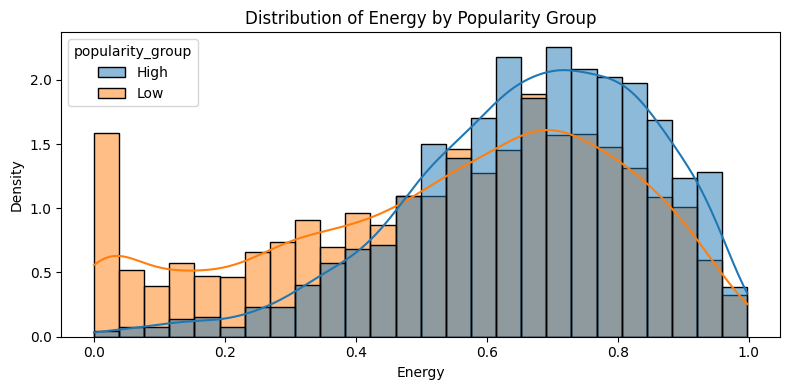

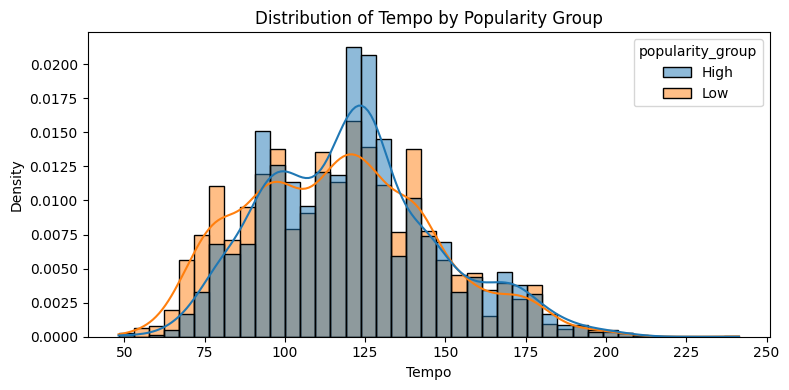

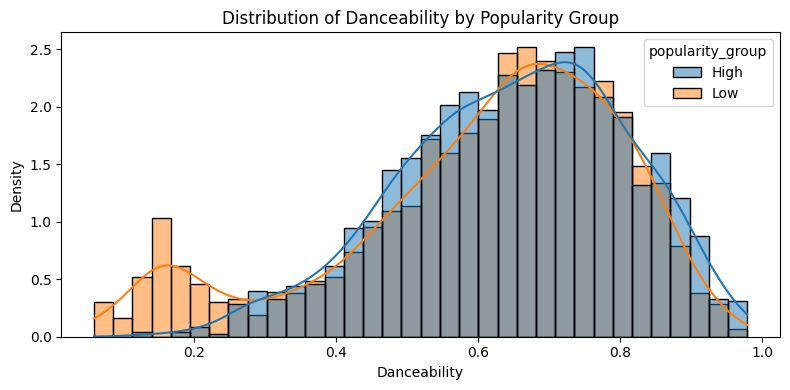

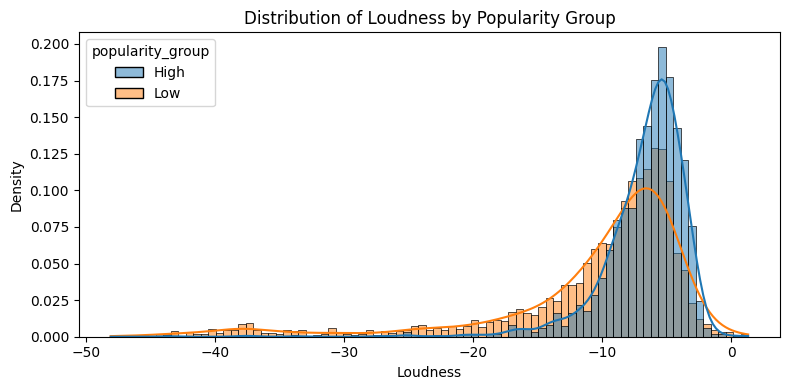

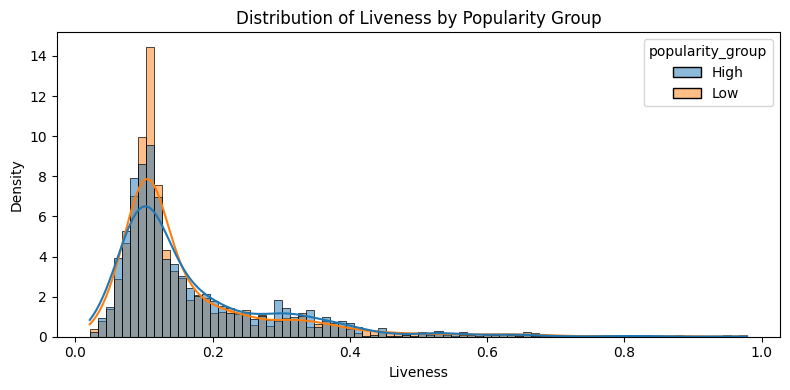

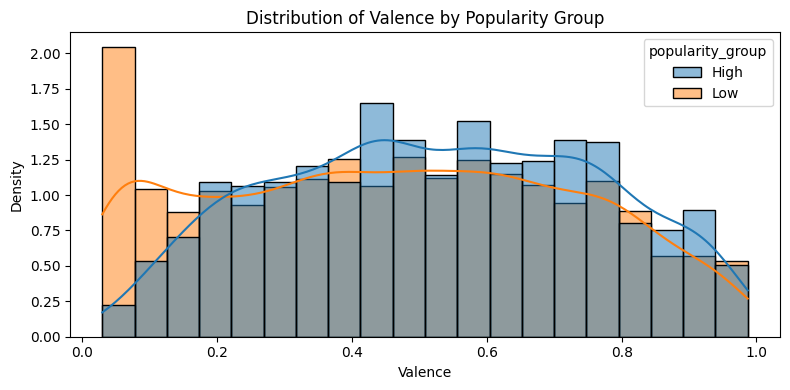

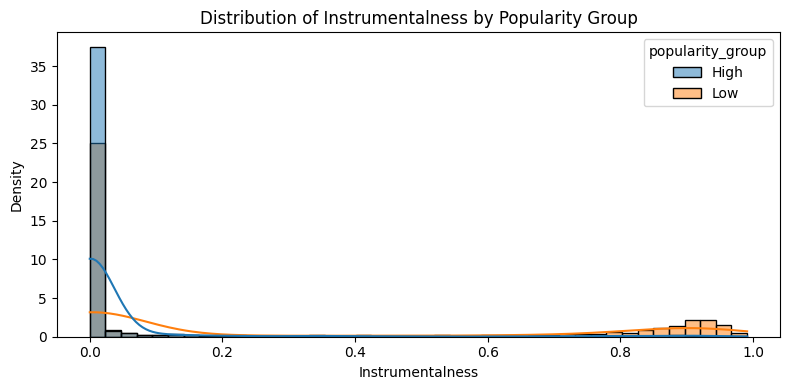

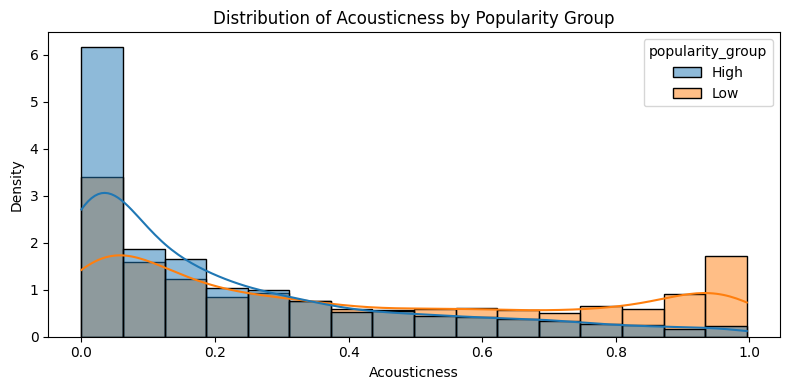

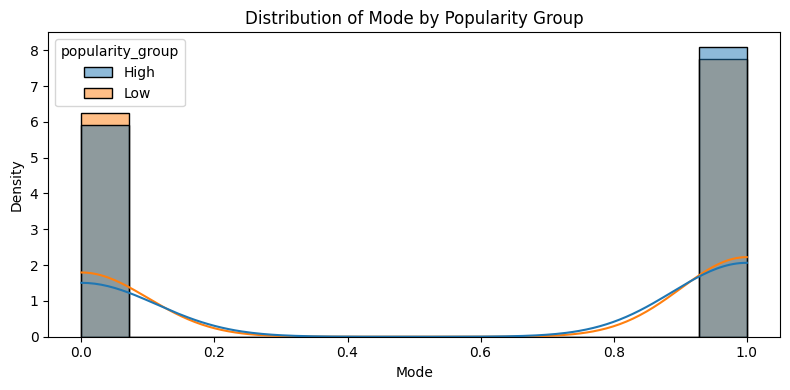

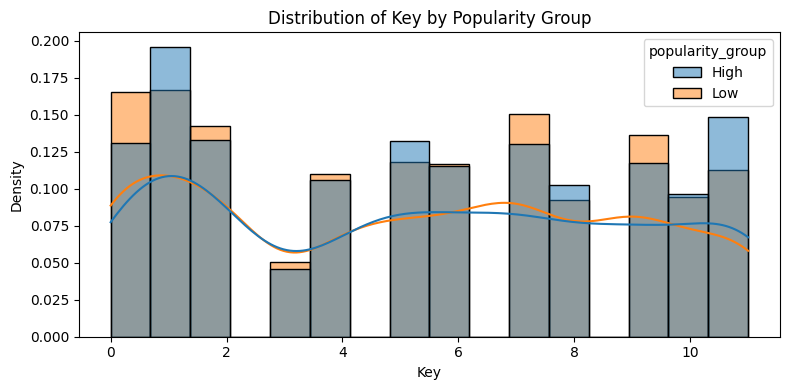

In [8]:
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=combined_df, x=feature, hue='popularity_group', kde=True,
                 stat='density', common_norm=False)
    plt.title(f'Distribution of {feature.capitalize()} by Popularity Group')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


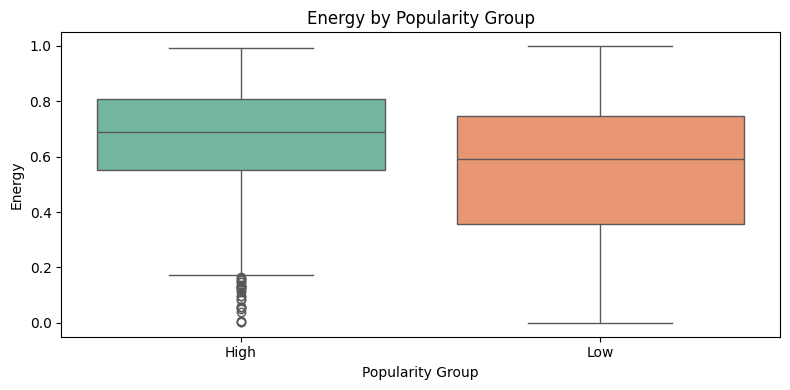

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


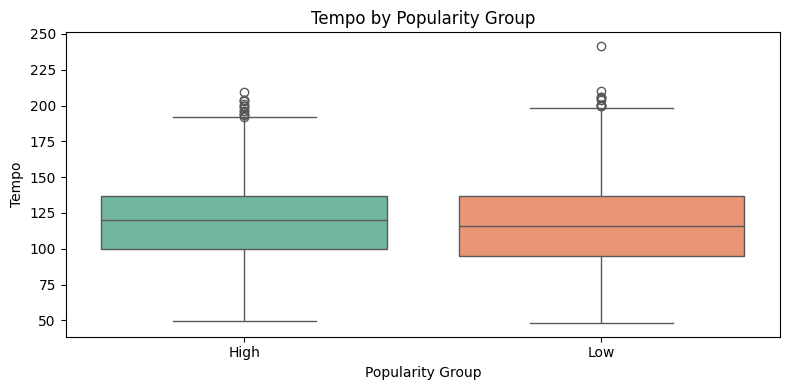

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


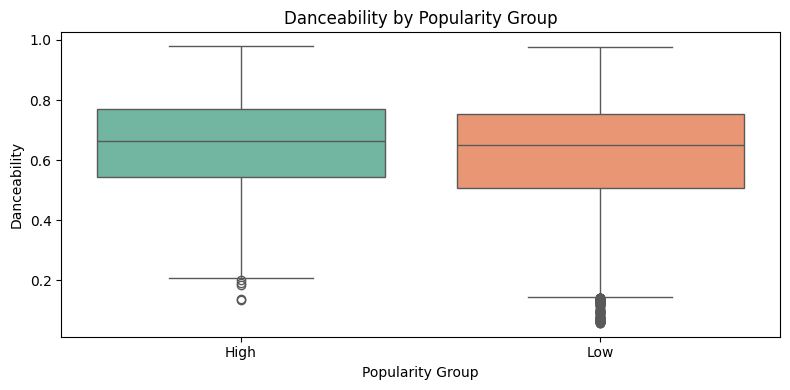

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


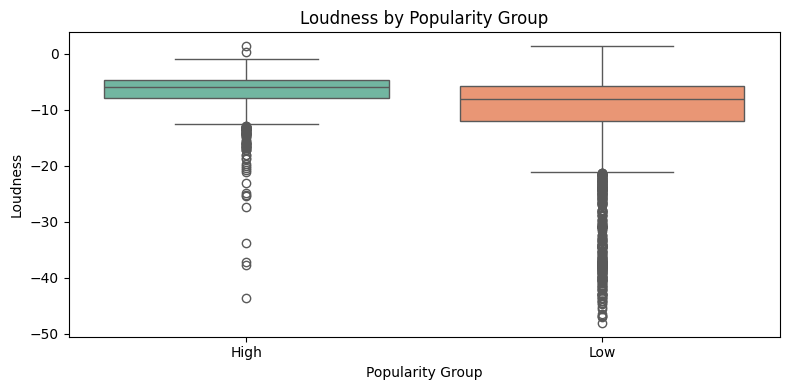

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


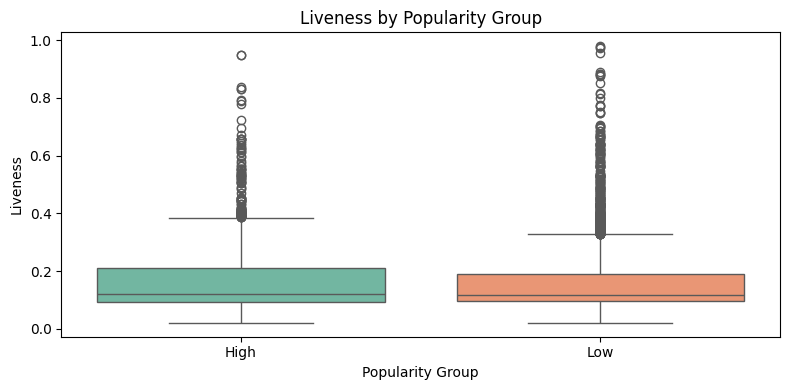

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


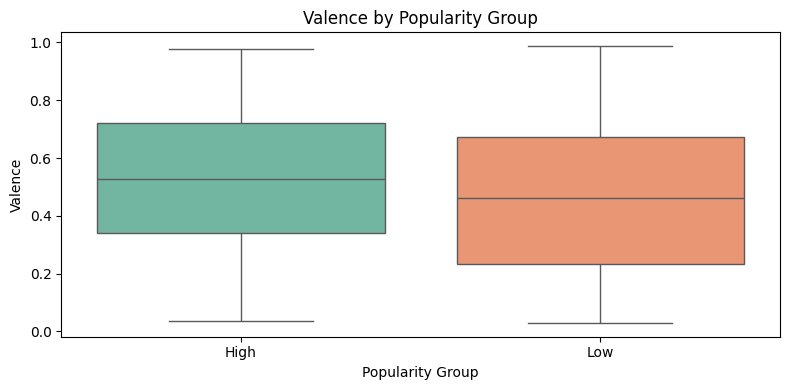

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


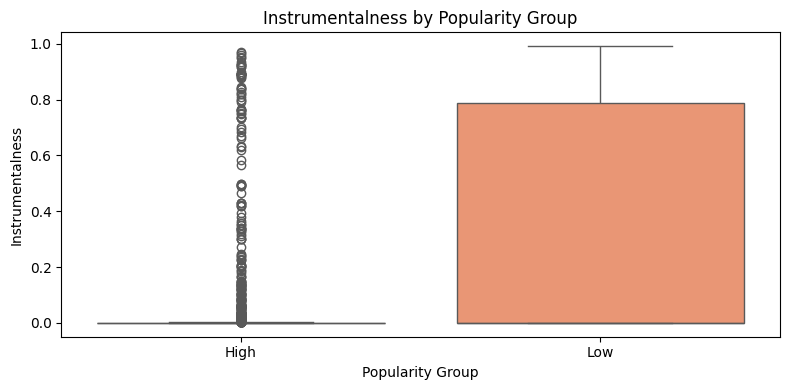

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


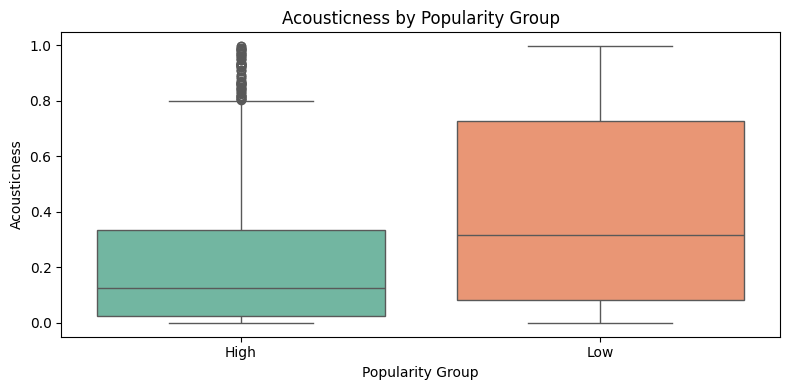

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


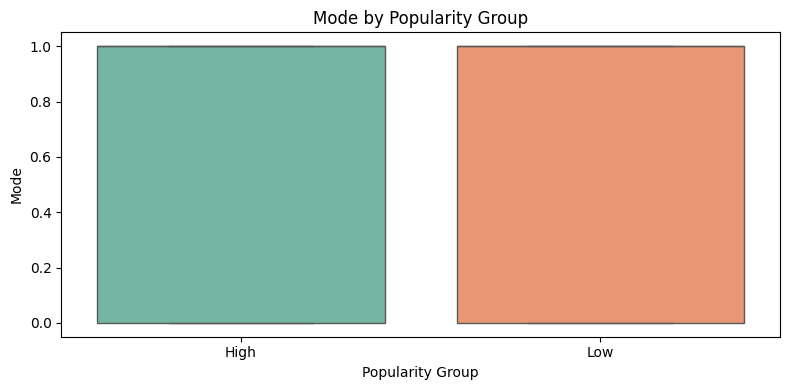

/var/folders/71/m64hwwrx4sngws9_kqly7zr40000gn/T/ipykernel_1929/2500628372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")


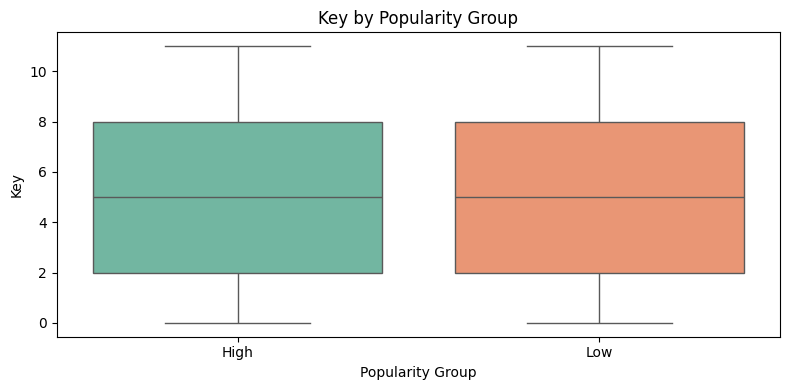

In [9]:
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=combined_df, x='popularity_group', y=feature, palette="Set2")
    plt.title(f'{feature.capitalize()} by Popularity Group')
    plt.xlabel('Popularity Group')
    plt.ylabel(feature.capitalize())
    plt.tight_layout()
    plt.show()

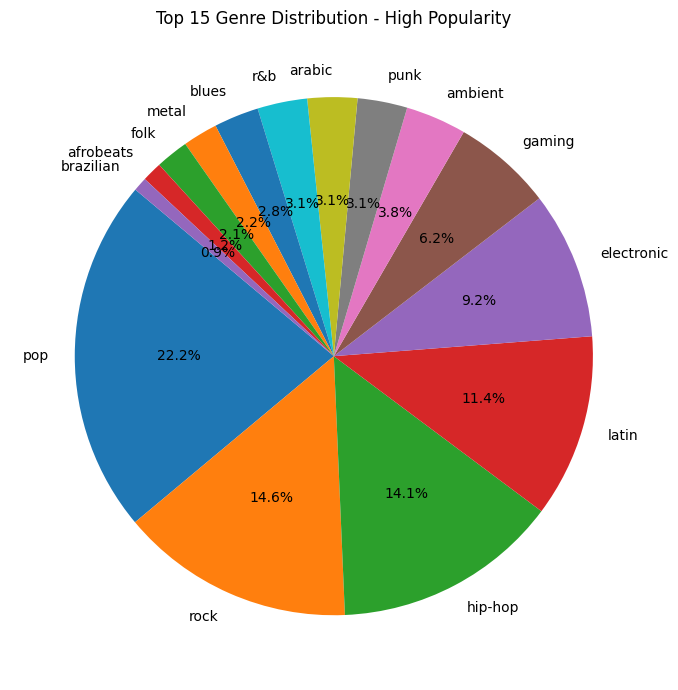

In [10]:
# High popularity
high_genre_counts = high_df['playlist_genre'].value_counts().head(15)  

plt.figure(figsize=(7, 7))
plt.pie(high_genre_counts, labels=high_genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 15 Genre Distribution - High Popularity')
plt.tight_layout()
plt.show()

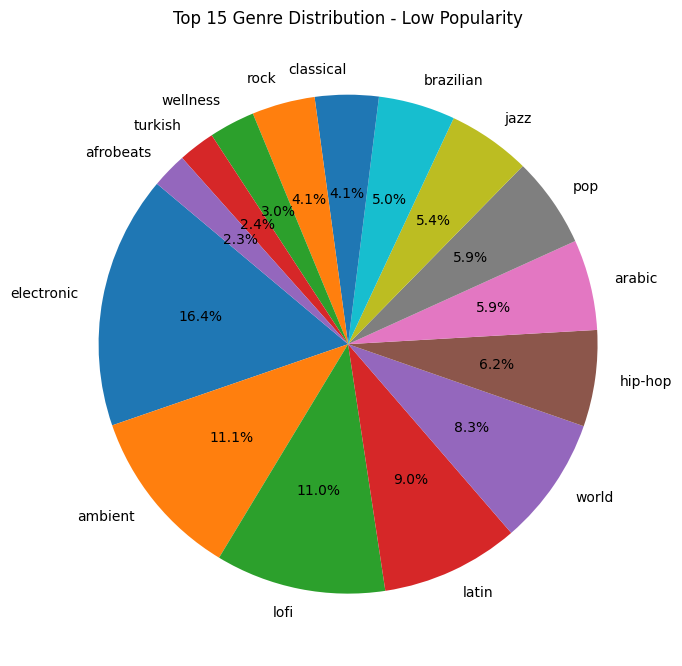

In [11]:
# Low popularity
low_genre_counts = low_df['playlist_genre'].value_counts().head(15)  

plt.figure(figsize=(7, 7))
plt.pie(low_genre_counts, labels=low_genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 15 Genre Distribution - Low Popularity')
plt.tight_layout()
plt.show()

In [12]:
df_all = pd.concat([high_df, low_df], ignore_index=True)

In [13]:
# List of numeric features to use
features_model = [
    'energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence',
    'speechiness', 'instrumentalness', 'mode', 'key', 'duration_ms',
    'acousticness', 'time_signature'
]

In [14]:
# Drop missing values
df_all = df_all.dropna(subset=features_model + ['track_popularity'])

In [15]:
X = df_all[features_model]
y = df_all['track_popularity']

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

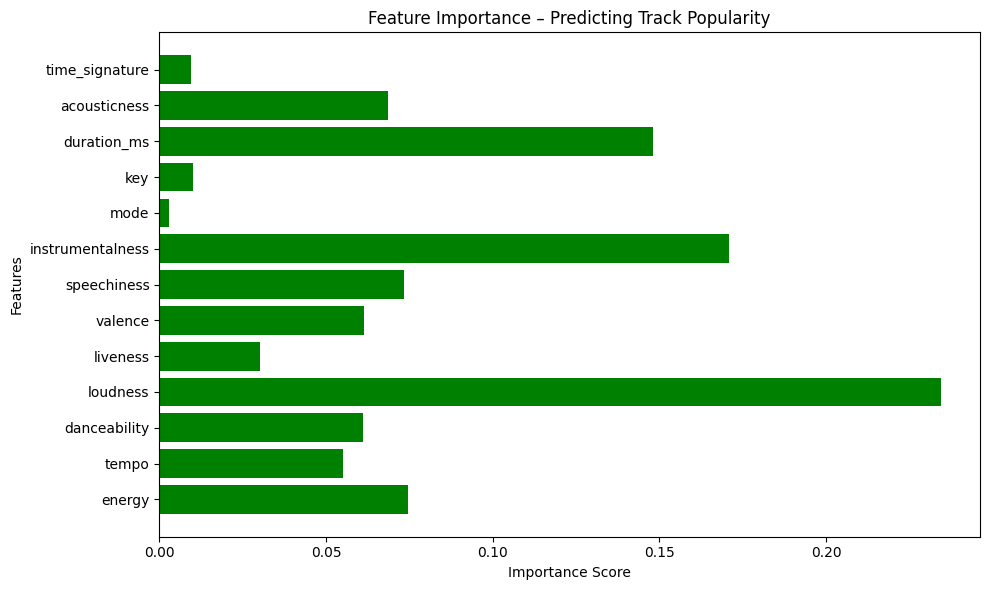

In [19]:
feature_importances = model_gb.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(features_model, feature_importances, color='green')
plt.title('Feature Importance – Predicting Track Popularity')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [20]:
correlation_matrix = df_all[features_model + ['track_popularity']].corr()

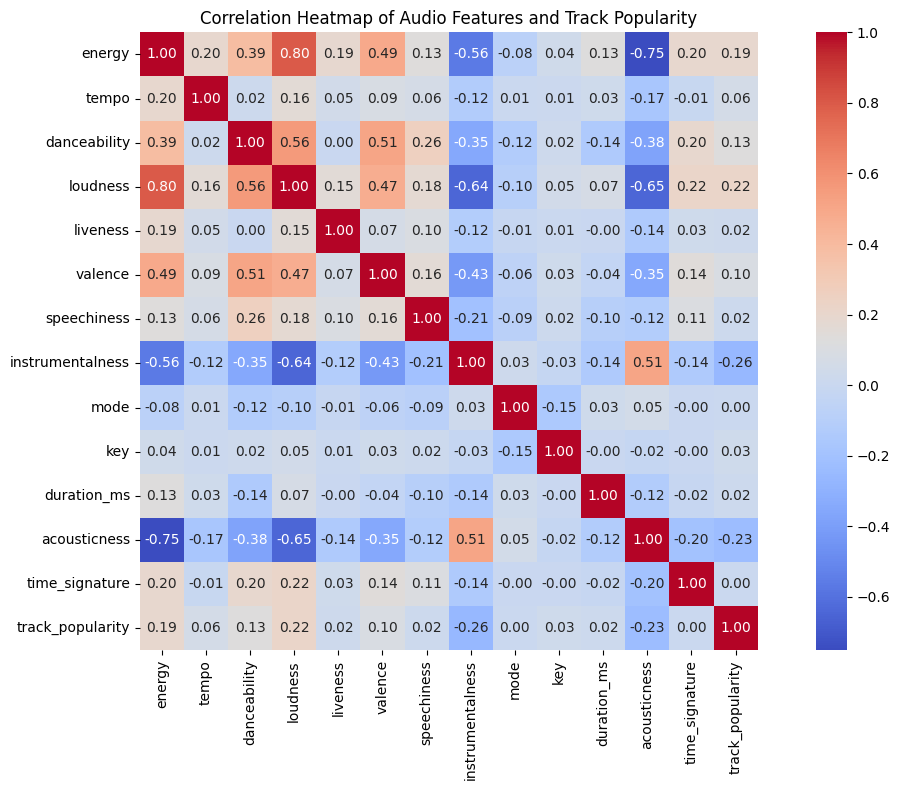

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Audio Features and Track Popularity')
plt.tight_layout()
plt.show()

### **Clustering - Carter Leonard and Rushil Jadia**

### What is Clustering?

Clustering is an unsupervised machine learning technique that groups similar data points together based on their features — without needing predefined labels. In this project, clustering is used to group songs with similar musical attributes such as Energy, Tempo, Valence, Danceability, Genre, and Artist.

Before we begin, we will import all necessary libraries and read the CSV file:

### **Clustering: Data Introduction**

In [27]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import *

### **Clustering Model 1: Hierarchical Clustering**

In [34]:
low_dataf = pd.read_csv("data/low_popularity_spotify_data.csv")
high_dataf = pd.read_csv("data/high_popularity_spotify_data.csv")

### **Hierarchical Clustering: Pre-Processing**

Here is the head of the lower dataframe:

In [35]:
low_dataf.head()

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.804,rock,classic,...,3S404OgKoVQSJ3xXrDVlp8,37i9dQZF1DWXRqgorJj26U,5LNiqEqpDc8TuqPy79kDBu,0.658,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition)
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.104,jazz,classic,...,1y5KGkUKO0NG32MhIIagCA,37i9dQZF1DXbITWG1ZJKYt,78MI7mu1LV1k4IA2HzKmHe,0.394,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella"
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.472,jazz,classic,...,6f4b9wVTkKAf096k4XG6x5,37i9dQZF1DXbITWG1ZJKYt,6MN6yRVriszuyAVlyF8ndB,0.475,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter


Here is the head of the higher dataframe:

In [36]:
high_dataf.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


### **Hierarchical Clustering: Modeling**

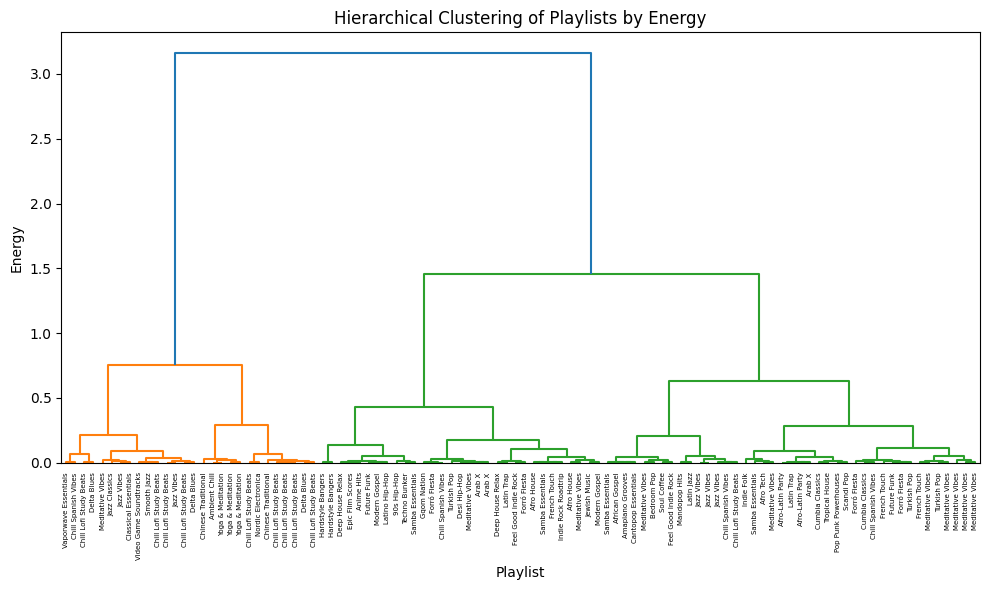

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage

df = pd.read_csv('data/low_popularity_spotify_data.csv')

df['energy'] = pd.to_numeric(df['energy'], errors = 'coerce')
df = df.dropna(subset=['energy'])

if len(df) > 100:
    df = df.sample(n=100, random_state=42).reset_index(drop=True)

energy_values = df[['energy']].values

linked = linkage(energy_values, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, 
           labels=df['playlist_name'].values,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering of Playlists by Energy')
plt.xlabel('Playlist')
plt.ylabel('Energy')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### **Hierarchical Clustering: Evaluation**

This hierarchical clustering combines playlist names with the energy that the user wants in a playlist. The top 100 playlists in the low popularity chart were graphed out to match the desired energy to the playlist that matches. Preparing the data was simple enough due to only singling out the two columns within the CSV file and then making sure the cluster was properly matching the playlists to their energy, ensuring that if a user wants a specific playlist within a certain amount of energy, that the search would be narrowed down and simple for the user.

### **Clustering Model 2: K-Means Clustering**

Now that we are testing another model, we will need to redo the pre-processing:

### **K-Means Clustering: Pre-Processing**

In [37]:
low_data = pd.read_csv("data/low_popularity_spotify_data.csv")
high_data = pd.read_csv("data/high_popularity_spotify_data.csv")

In [38]:
df = pd.concat([high_data, low_data], ignore_index=True)

Now that we've combined the high and low dataframes, we are able to get a better representation of the data! We will move into deciding what factors will determine the accuracy of this recommender system.

In [39]:
features = ['energy', 'tempo', 'valence', 'danceability', 'track_artist','playlist_name', 'playlist_genre', 'playlist_subgenre']

We need to drop all nulls for this model and remove all unnecessary info from the dataframe.

In [40]:
df = df[features].dropna()

We will split the columns into different genres: Categorical and Numerical features:

In [41]:
numerical_features = ['energy', 'tempo', 'valence', 'danceability']
categorical_features = ['track_artist', 'playlist_name', 'playlist_genre', 'playlist_subgenre']

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

### **K-Means Clustering: Modeling**

Before we begin the clustering process, we will transform the data.

In [43]:
X = preprocessor.fit_transform(df)

In [44]:
df_cols = list(df.columns)

dummy_vars = []
for var in categorical_features:
    feature_list = set(df[var].to_list())
    dummy_vars.append(feature_list)

X_cols = list(df_cols + dummy_vars)

In [46]:
X.shape

(4830, 3628)

In [47]:
print(len(X_cols))

12


Now that we made necessary changes before actually beginning the clustering process, we should check what the ideal amount of clusters is to make these predictions.

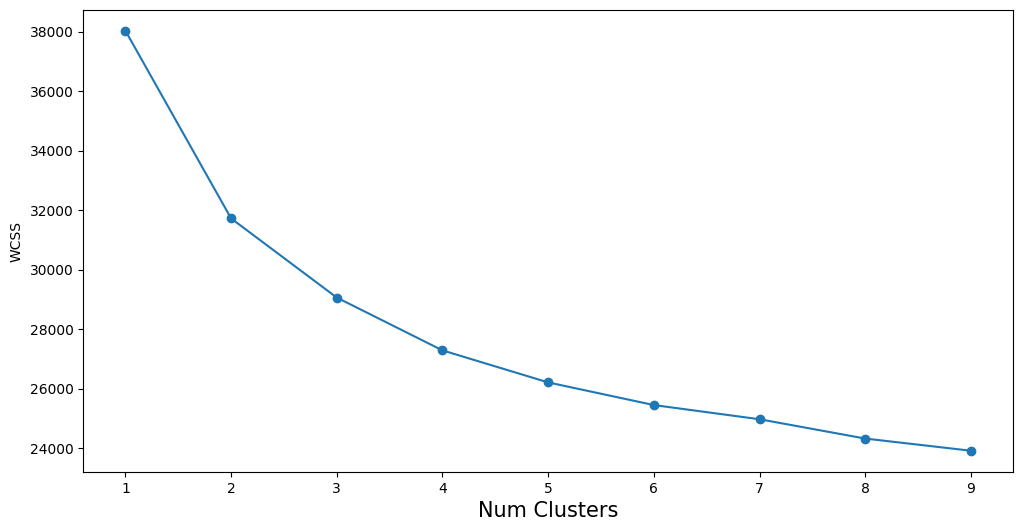

In [ ]:
inertias = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1,10), inertias, marker ='o')
plt.xlabel('Num Clusters', fontsize = 15)
plt.ylabel('WCSS')
plt.show()

As expected, the lesser number of clusters, the higher chance of accuracy. Now we can actually begin, by using K-Means:

In [49]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
df['kmeans_cluster'] = kmeans_labels
print("KMeans Silhouette Score:", silhouette_score(X, kmeans_labels))

KMeans Silhouette Score: 0.18093874382786207


Looks like it worked, but the Silhouette score is very low. We may need to reduce the sample size, so we will use PCA for this next section. Using PCA, we will do dimensionality reduction, and visualize the silhouettes scores for each PC.

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X)
loadings = pca.components_
loadings

array([[ 0.55899483,  0.17875636,  0.58766156, ..., -0.00179783,
         0.00186416, -0.03127674],
       [ 0.14789075,  0.92575342, -0.14487857, ...,  0.00114007,
         0.0012608 ,  0.00373005],
       [ 0.67363694, -0.32575888,  0.0062428 , ...,  0.00177847,
         0.00142304,  0.00294286]], shape=(3, 3628))

In [51]:
pca_df = pd.DataFrame(
    reduced_data, 
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['Cluster'] = kmeans_labels  # Append cluster labels for plotting

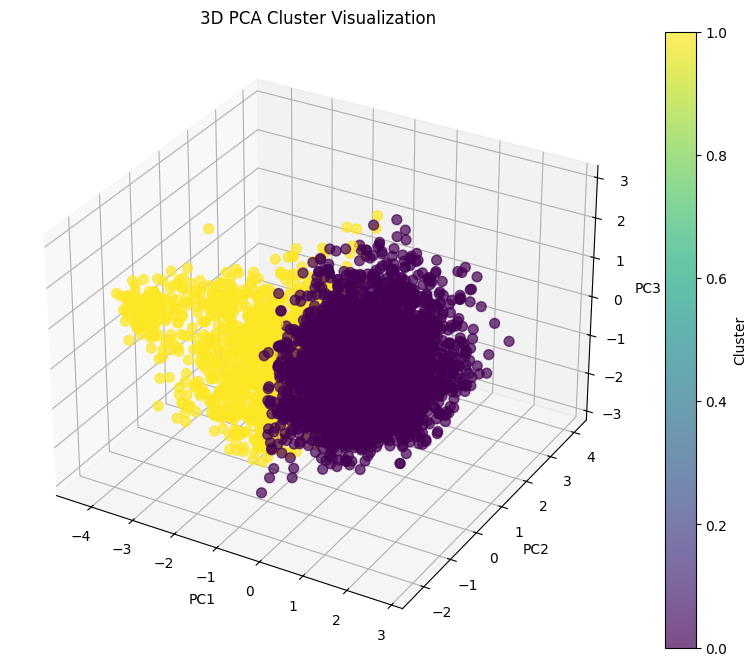

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    pca_df['PC3'], 
    c=pca_df['Cluster'], 
    cmap='viridis', 
    s=50,
    alpha=0.7
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Cluster Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

Here we have a 3-D graph visualizing the PCA clusters, and how much the silhouette score would be around. The color bar on the right helps us identify each cluster. It seems that there is a higher score than before, but there is still a low score overall.

Now we will run K-Means again to see if we have a more accurate representation:

In [53]:
# Use the reduced data for clustering
kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_labels_pca = kmeans_pca.fit_predict(reduced_data)

# Evaluate new silhouette score
from sklearn.metrics import silhouette_score
print("Silhouette Score (after PCA):", silhouette_score(reduced_data, kmeans_labels_pca))

Silhouette Score (after PCA): 0.3688860714385388


It seems as if the silhouette score did increase, which is a good sign. However, it doesn't seem accurate enough to recommend songs to a user based on these features. We will try to reduce outliers by computing Z-Scores across PCA components and keeping rows where all PC's have z > 3. We will then filter the reduced and original data and run the K-Means algorithm againt to see if there is an increase in the silhouette score.

Z-Score & Reducing Outliers

In [54]:
from scipy.stats import zscore

# Compute z-scores across PCA components
z_scores = np.abs(zscore(reduced_data))
outlier_mask = (z_scores < 3).all(axis=1)  # Keep rows where all PCs have z < 3

# Filter the reduced and original data
reduced_data_filtered = reduced_data[outlier_mask]
X_filtered = X[outlier_mask]

In [55]:
kmeans_filtered = KMeans(n_clusters=2, random_state=42)
labels_filtered = kmeans_filtered.fit_predict(reduced_data_filtered)

print("Silhouette Score (after outlier removal):", silhouette_score(reduced_data_filtered, labels_filtered))

Silhouette Score (after outlier removal): 0.3688377212817695


### **K-Means Clustering: Evaluation**

After these tests and changes made to the dataframe to fit our goal, it seems as if K-Means is not the best clustering approach to meet our goals and help solve our problem. However, we are able to gain insight on what factors should be considered and how much data we should test to create a recommender system. For example, the subgenres column has many unique values, and may even categorize a subgenre as an artist's name or make a similar issue. Those factors need to be avoided when it comes to clustering and perhaps a better modeling approach should be taken to create this recommender system.

### **Recommender System - Bita Ghaffari and Sindhu Gadiraju**

This project implements a content-based song recommender system using audio features extracted from two datasets of high- and low-popularity songs. The main goal of the system is to suggest songs that are musically similar to a given input track based on its acoustic characteristics.

In [108]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [117]:
high_popularity_df = pd.read_csv("data/high_popularity_spotify_data.csv")
low_popularity_df = pd.read_csv("data/low_popularity_spotify_data.csv")

In [119]:
high_popularity_df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


In [120]:
low_popularity_df.head()

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.804,rock,classic,...,3S404OgKoVQSJ3xXrDVlp8,37i9dQZF1DWXRqgorJj26U,5LNiqEqpDc8TuqPy79kDBu,0.658,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition)
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.104,jazz,classic,...,1y5KGkUKO0NG32MhIIagCA,37i9dQZF1DXbITWG1ZJKYt,78MI7mu1LV1k4IA2HzKmHe,0.394,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella"
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.472,jazz,classic,...,6f4b9wVTkKAf096k4XG6x5,37i9dQZF1DXbITWG1ZJKYt,6MN6yRVriszuyAVlyF8ndB,0.475,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter


In [121]:
combined_df = pd.concat([high_popularity_df, low_popularity_df])

In [122]:
print(combined_df.columns)

Index(['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness',
       'liveness', 'valence', 'track_artist', 'time_signature', 'speechiness',
       'track_popularity', 'track_href', 'uri', 'track_album_name',
       'playlist_name', 'analysis_url', 'track_id', 'track_name',
       'track_album_release_date', 'instrumentalness', 'track_album_id',
       'mode', 'key', 'duration_ms', 'acousticness', 'id', 'playlist_subgenre',
       'type', 'playlist_id'],
      dtype='object')


In [123]:
print(combined_df.shape)

(4831, 29)


* 4831 rows, 29 columns
* combined dataset has 4831 entries & each row contains 29 attributes or features.

### How the Recommender System works

The system focuses on audio-based features that influence the musical "feel" of a song, such as: Energy

1. Tempo

2. Danceability

3. Loudness

4. Liveness

5. Valence

6. Instrumentalness

7. Acousticness

8. Mode

9. Key

These features are selected because they are intrinsic to the audio signal and directly shape the listening experience, making them suitable for content-based recommendation.

### **Recommender System: Pre-Processing**

* The dataset is first cleaned by removing metadata (e.g., artist names, album IDs, playlist names) that are not useful for computing similarity.

* The selected audio features are standardized using StandardScaler to ensure that each feature contributes equally to the similarity score.

* A cosine similarity matrix is computed using the standardized feature vectors. Cosine similarity measures how close two songs are in the multi-dimensional feature space, regardless of magnitude.

In [124]:
# Drop columns that aren't relevant for the recommendation system
columns_to_drop = ['playlist_genre', 'track_artist', 'track_popularity', 'track_href', 
                  'uri', 'track_album_name', 'track_album_id', 'track_album_release_date', 
                  'analysis_url', 'time_signature', 'playlist_name', 'playlist_subgenre', 'playlist_id']
combined_df = combined_df.drop(columns=columns_to_drop)

In [126]:
# Select the audio-related features
features = ['energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence', 
            'instrumentalness', 'acousticness', 'mode', 'key']

# Standardize these features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Add the scaled features back to the DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df['track_name'] = combined_df['track_name'].values  # Keep track name for reference

# Drop rows with any NaNs in selected features
scaled_df = scaled_df.dropna(subset=features)

### Calculate Cosine Similarities

**Recommendation**

* When a user inputs a song name:
1. The system identifies its index in the dataset.

2. It retrieves similarity scores between that song and all others using the cosine similarity matrix.

3. It ranks the songs by similarity (excluding the input song itself).

4. It returns the top N most similar songs.

In [127]:
# Step 1: Compute cosine similarity matrix
similarity_matrix = cosine_similarity(scaled_df[features])

# Step 2: Recommender function
def recommend_song(song_name, df, sim_matrix, top_n=5):
    if song_name not in df['track_name'].values:
        print("Song not found.")
        return
    
    # Get the index of the song
    idx = df[df['track_name'] == song_name].index[0]
    
    # Get similarity scores for the song
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    # Sort by similarity score (excluding the song itself)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Print top recommendations
    print(f"\nTop {top_n} songs similar to '{song_name}':")
    for i, (song_idx, score) in enumerate(sim_scores):
        similar_song = df.iloc[song_idx]['track_name']
        print(f"{i+1}. {similar_song} (Similarity Score: {score:.2f})")


In [128]:
recommend_song("Shape of You", scaled_df, similarity_matrix)


Top 5 songs similar to 'Shape of You':
1. Shape of You (Similarity Score: 1.00)
2. Because Of You (Similarity Score: 0.96)
3. Matuto Aperreado (Similarity Score: 0.95)
4. Baby (Similarity Score: 0.94)
5. Personal (Similarity Score: 0.94)


### Example Result

* For the input song "Shape of You", the system returned the following top 5 similar songs:
1. Because Of You (Similarity Score: 0.96)

2. Matuto Aperreado (0.95)

3. Baby (0.94)

4. Personal (0.94)

* These results demonstrate that the system is successfully identifying songs with similar musical structures and energy levels, regardless of artist or genre. This recommender system provides an efficient and interpretable method for finding musically similar songs. By leveraging cosine similarity on standardized audio features, it avoids biases from popularity and focuses on content alone. It serves as a solid foundation for more advanced hybrid systems that could incorporate collaborative filtering or deep learning in future iterations.